# Hate Speech Detection
This notebook performs hate speech detection on a dataset of tweets. The pipeline is as follows:
- Load & preprocess data
- Finetune a pretrained RoBERTa model for hate speech classification
- Evaluate the model on the test set

### Setup

#### Imports

In [2]:
# imports
# standard
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
# from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
# custom
from src.utils import *
from src.models import HateSpeechClassifier
from src.train import train_pl
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Train model

In [9]:
# %%script false --no-raise-error
# clear GPU memory
torch.cuda.empty_cache()

# create data loaders
data_path = 'data/hs_davidson2017.csv'
bsz = 64
max_len = 256
num_workers = 12
tokenizer = AutoTokenizer.from_pretrained('roberta-large')
train_loader, val_loader, test_loader = create_data_loaders(data_path, tokenizer, max_len, bsz, num_workers)

# create the model
model = HateSpeechClassifier('roberta-large', pos_weight=10.0)

# training args
args = {'num_epochs': 10, 'precision': '16-mixed', 'patience': 3, 'ckpt_name': 'ckpt_best', 'resume_ckpt': None}

# train
model, trainer = train_pl(model, train_loader, val_loader, args)

# test
trainer.test(dataloaders=test_loader)

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using 16bit Automatic Mixed Pr

Epoch 0: 100%|██████████| 310/310 [02:12<00:00,  2.35it/s, v_num=26]       

Metric val_loss improved. New best score: 1.033


Epoch 1: 100%|██████████| 310/310 [02:12<00:00,  2.33it/s, v_num=26]

Metric val_loss improved by 0.058 >= min_delta = 0.0001. New best score: 0.975


Epoch 4: 100%|██████████| 310/310 [02:12<00:00,  2.34it/s, v_num=26]

Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.975


Epoch 7: 100%|██████████| 310/310 [02:12<00:00,  2.34it/s, v_num=26]

Monitored metric val_loss did not improve in the last 3 records. Best score: 0.975. Signaling Trainer to stop.


Epoch 7: 100%|██████████| 310/310 [02:39<00:00,  1.94it/s, v_num=26]


/opt/conda/envs/aiahs/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:148: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
Restoring states from the checkpoint path at /home/neil/aiahs/model_ckpts/ckpt_best.ckpt


training on device: cpu


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/neil/aiahs/model_ckpts/ckpt_best.ckpt


Testing DataLoader 0: 100%|██████████| 39/39 [00:05<00:00,  7.78it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Runningstage.testing metric      DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.949979841709137
     test_acc_epoch          0.915520966053009
        test_loss           0.9341363906860352
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.9341363906860352,
  'test_acc': 0.949979841709137,
  'test_acc_epoch': 0.915520966053009}]

In [10]:
# get test predictions
test_out = trainer.predict(dataloaders=test_loader)
# stack batch preds and labels
test_labels = torch.cat([x[0] for x in test_out]).cpu().numpy() 
test_preds = torch.cat([x[1] for x in test_out])
# get value counts of 0's & 1's in test_labels, test_preds
unique_labels, counts_labels = np.unique(test_labels, return_counts=True)
unique_preds, counts_preds = np.unique(test_preds, return_counts=True)

# print the counts
print(f"counts in test_labels: {dict(zip(unique_labels, counts_labels))}")
print(f"counts in test_preds: {dict(zip(unique_preds, counts_preds))}")

/opt/conda/envs/aiahs/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:148: UserWarning: `.predict(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.predict(ckpt_path='best')` to use the best model or `.predict(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
Restoring states from the checkpoint path at /home/neil/aiahs/model_ckpts/ckpt_best.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/neil/aiahs/model_ckpts/ckpt_best.ckpt


Predicting DataLoader 0: 100%|██████████| 39/39 [00:04<00:00,  7.93it/s]
counts in test_labels: {0: 2355, 1: 124}
counts in test_preds: {0: 2479}


## EOOH

### Viz EOOH annotations

In [38]:
# load eooh annotations for dataset
pd.set_option('display.max_colwidth', 30)
df_hs = pd.read_csv('data/hs_davidson2017.csv')
df_hs['class'] = df_hs['class'].apply(lambda x: 1 if x == 0 else 0) # convert to 0/1 labels
# get value counts for each class
print(f'hate speech gt labels in original data: {df_hs["class"].value_counts(normalize=True)}')
print(f'hate speech gt labels in train set: {df_hs[df_hs["split"] == "train"]["class"].value_counts(normalize=True)}')
print(f'hate speech gt labels in test set: {df_hs[df_hs["split"] == "test"]["class"].value_counts(normalize=True)}')

df_hs_eooh = pd.read_csv('data/hs_davidson2017_eooh_analyzed.csv')
# df_hs_eooh.head()
# print(df_hs_eooh.head())

hate speech gt labels in original data: class
0    0.942299
1    0.057701
Name: proportion, dtype: float64
hate speech gt labels in train set: class
0    0.940886
1    0.059114
Name: proportion, dtype: float64
hate speech gt labels in test set: class
0    0.94998
1    0.05002
Name: proportion, dtype: float64


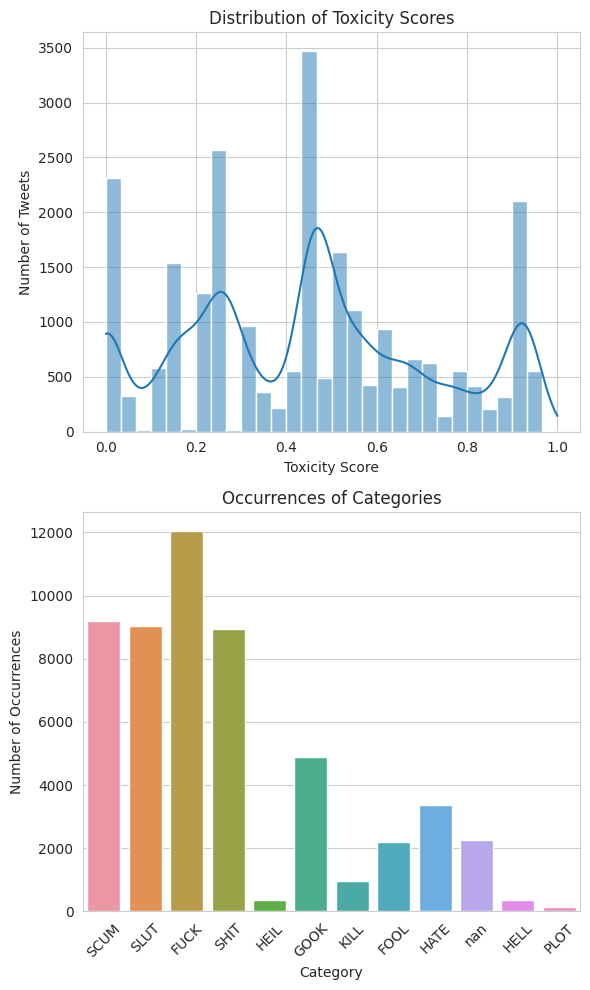

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Set the style of seaborn for better visualization
sns.set_style("whitegrid")

# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(6, 10))

# Plotting the histogram for toxicity scores on the first subplot
sns.histplot(df_hs_eooh['toxicity'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Distribution of Toxicity Scores')
axes[0].set_xlabel('Toxicity Score')
axes[0].set_ylabel('Number of Tweets')

# Ensure all entries in 'categories' are strings
df_hs_eooh['categories'] = df_hs_eooh['categories'].astype(str)

# Splitting the categories and counting occurrences
categories = df_hs_eooh['categories'].str.split().sum()
category_counts = Counter(categories)

# Plotting the top categories
sns.barplot(x=list(category_counts.keys()), y=list(category_counts.values()), ax=axes[1])
axes[1].set_title('Occurrences of Categories')
axes[1].set_xlabel('Category')
axes[1].set_ylabel('Number of Occurrences')
axes[1].tick_params(axis='x', rotation=45)

# Adjust the layout
plt.tight_layout()
plt.show()

### Evaluate annotations

In [37]:
# define toxicity threshold (for hate speech)
df_hs = pd.read_csv('data/hs_davidson2017.csv')

# preprocess raw data
df_hs = df_hs.loc[:, ['tweet', 'class', 'split']]
df_hs['class'] = df_hs['class'].apply(lambda x: 1 if x == 0 else 0)  # binary indicator of hate_speech or not

# classify tweets using EOOH's classifier
toxic_thresh = 0.1
df_hs['class_eooh'] = df_hs_eooh['toxicity'].apply(lambda x: 1 if x >= toxic_thresh else 0)


# classify tweets using finetuned RoBERTa model
# load model
# make predictions on test split

# compute accuracy for both models on test split

                           tweet  class  split  class_eooh
0  !!! RT @mayasolovely: As a...      0  train           1
1  !!!!! RT @mleew17: boy dat...      0  train           1
2  !!!!!!! RT @UrKindOfBrand ...      0  train           1
3  !!!!!!!!! RT @C_G_Anderson...      0  train           1
4  !!!!!!!!!!!!! RT @ShenikaR...      0  train           1
accuracy of EOOH classifier: 0.156
